In [1]:
import numpy as np
import matplotlib.pyplot as plt
from env.dynaQ_maze import DynaQMaze
from dyna_q import DynaQ

## Setup the environment

In [2]:
start_location = (2, 0)
target_location = (0, 8)
rows = 6
columns = 9
block_positions = [[1, 2], [2, 2], [3, 2], [4, 5], [0, 7], [1, 7], [2, 7]]
env = DynaQMaze(rows=rows, 
                columns=columns, 
                block_positions=block_positions, 
                start_location=start_location, 
                target_location=target_location)

num_actions = env.action_space.n

## Tabular Dyna-Q

In [3]:
gamma = 0.95
epsilon = 0.1
alpha = 0.1
episodes = 50
planning_steps = [0, 5, 50]
runs = 30
results = {}


for n in planning_steps:
    print("n =", n)
    mean_steps_per_episode = np.zeros((episodes,), dtype=np.float32)

    for run in range(runs):
        dyna = DynaQ(
            num_actions=num_actions,
            add_bonus=False,
            gamma=gamma,
            epsilon=epsilon,
            planning_steps=n,
            seed=123,
            alpha=alpha
        )

        for _ in range(episodes):
            dyna.run_episode(env)
        mean_steps_per_episode += np.array(dyna.steps_per_episode)
        print(f"\rrun={run:<4}", end='')
    results[n] = mean_steps_per_episode / runs
    print()


n = 0
run=29  
n = 5
run=29  
n = 50
run=29  


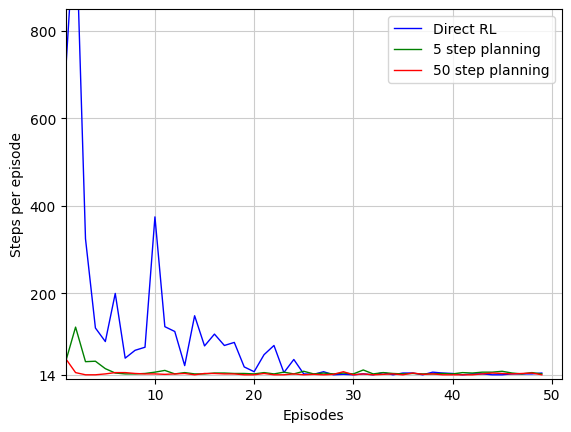

In [4]:
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(results[0], label='Direct RL', c='blue', linewidth=1)
ax.plot(results[5], label='5 step planning', c='green', linewidth=1)
ax.plot(results[50], label='50 step planning', c='red', linewidth=1)
ax.set_ylim([5, 850])
ax.set_yticks([14, 200, 400, 600, 800]);
ax.set_xlim([1, 51])
ax.grid(c="#ccc")
ax.legend();
ax.set_xlabel("Episodes")
ax.set_ylabel("Steps per episode");